In [1]:
import xgboost as xgb
import wandb
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from ift6758.data import load_cached_season_dataframe, load_cached_seasons_dataframe, new_variables, goal_rate_by_percentile
from ift6758.data.graphs import plot_goal_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [2]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin
df = new_variables(df_training)
df_training # petit apperçu

,timeInPeriod,gameSeconds,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,...,lastEventY,timeSinceLastEvent,distanceSinceLastEvent,goalStrenght,friendlySkaters,opposingSkaters,timeInPowerPlay,gameId,season,gameType
0,01:11,71,1,8,TOR,shot-on-goal,-77.0,5.0,Mitch Marner,Craig Anderson,...,11.0,1.0,17.088007,EV,5,5,0,2016020001,2016,2
1,02:53,173,1,11,OTT,shot-on-goal,86.0,13.0,Chris Kelly,Frederik Andersen,...,-5.0,5.0,36.715120,EV,5,5,0,2016020001,2016,2
2,04:01,241,1,15,OTT,shot-on-goal,23.0,-38.0,Cody Ceci,Frederik Andersen,...,0.0,18.0,102.318131,EV,5,5,0,2016020001,2016,2
3,04:46,286,1,16,OTT,shot-on-goal,33.0,-15.0,Erik Karlsson,Frederik Andersen,...,-2.0,19.0,45.880279,EV,5,5,0,2016020001,2016,2
4,06:46,406,1,24,TOR,shot-on-goal,-34.0,28.0,Martin Marincin,Craig Anderson,...,34.0,16.0,81.221918,EV,5,5,0,2016020001,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,16:01,3361,3,706,TBL,shot-on-goal,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,...,-26.0,3.0,123.016259,SH,4,5,0,2019030416,2019,3
327338,17:20,3440,3,709,TBL,shot-on-goal,-81.0,3.0,Blake Coleman,Anton Khudobin,...,6.0,2.0,3.162278,SH,4,5,0,2019030416,2019,3
327339,18:50,3530,3,713,DAL,shot-on-goal,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,...,-16.0,8.0,58.855756,EV,6,5,0,2019030416,2019,3
327340,19:27,3567,3,719,DAL,shot-on-goal,31.0,10.0,John Klingberg,Andrei Vasilevskiy,...,-22.0,5.0,49.678969,EV,6,5,0,2019030416,2019,3


## Séparation des ensembles d'entraînement et de validation

In [3]:
feature_sets = {
    "Distance": ["shotDistance"],
    "Angle": ["shotAngle"],
}

two_features = sorted({col for cols in feature_sets.values() for col in cols})

X_distance_angle = df[two_features].copy()
y_distance_angle = df["isGoal"].astype(int)

mask = X_distance_angle.notna().all(axis=1)
X_distance_angle = X_distance_angle.loc[mask]
y_distance_angle = y_distance_angle.loc[mask]

X_train_distance_angle, X_val_distance_angle, y_train_distance_angle, y_val_distance_angle = train_test_split(X_distance_angle, y_distance_angle, test_size=0.2, random_state=42)

# Modèle XGBoost avec la distance et l'angle

In [4]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-baseline-dist-angle",
    tags=["baseline", "xgboost"],
    save_code=True
)

XGBoost_distance_angle = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

XGBoost_distance_angle.fit(X_train_distance_angle, y_train_distance_angle)

# Prédictions
y_pred_distance_angle = XGBoost_distance_angle.predict(X_val_distance_angle)
y_proba_distance_angle = XGBoost_distance_angle.predict_proba(X_val_distance_angle)

# 6. Calcul des métriques
acc_distance_angle = accuracy_score(y_val_distance_angle, y_pred_distance_angle)
auc_distance_angle = roc_auc_score(y_val_distance_angle, y_proba_distance_angle[:, 1])
ll_distance_angle = log_loss(y_val_distance_angle, y_proba_distance_angle[:, 1])

print(f"Accuracy: {acc_distance_angle}")
print(f"AUC: {auc_distance_angle}")
print(f"Log Loss: {ll_distance_angle}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    XGBoost_distance_angle, X_train_distance_angle, X_val_distance_angle, y_train_distance_angle, y_val_distance_angle,
    y_pred_distance_angle, y_proba_distance_angle, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost Baseline', 
    feature_names=['distance', 'angle']
)

wandb.log({"accuracy": acc_distance_angle, "auc": auc_distance_angle, "log_loss": ll_distance_angle})

run.finish()

wandb: Currently logged in as: stefan-sucatu (stefan-sucatu-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accuracy: 0.9059191934621553
AUC: 0.7153947569488606
Log Loss: 0.28689577826097273


wandb: 
wandb: Plotting XGBoost Baseline.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.90592
auc,0.71539
log_loss,0.2869


### Matrice de confusion

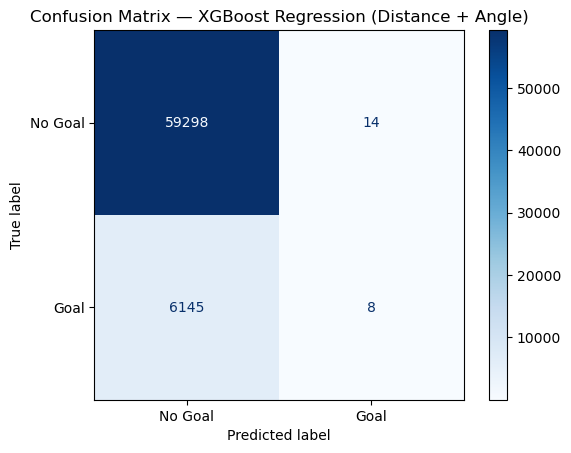

In [5]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_val_distance_angle, y_pred_distance_angle,
    display_labels=["No Goal", "Goal"],   
    values_format="d",
    cmap="Blues"
)
plt.title("Confusion Matrix — XGBoost Regression (Distance + Angle)")
plt.grid(False)
plt.show()

# XGBoost sur tous les features + calibration des hyperparamètres

In [6]:
feature_sets = {
    "Time": ["gameSeconds"],
    "Period": ["period"],
    "Coordinates": ["x", "y"],          # ou ["x_adj","y_adj"] si tu veux
    "Distance": ["shotDistance"],
    "Angle": ["shotAngle"],
    "ShotType": ["typeShot"],           # catégorielle
    "LastEvent": ["lastEvent"],
    "LastEventCoordinates":["lastEventX", "lastEventY"], 
    "TimeSinceLastEvent": ["timeSinceLastEvent"], 
    "DistanceSinceLastEvent": ["distanceSinceLastEvent"], 
    "Rebond": ["isRebound"], 
    "ChangementAngle": ["angleDifference"], 
    "Vitesse": ["speed"], 
    "PPTime": ["timeInPowerPlay"],
    "SkatersFriendly": ["friendlySkaters"],
    "SkatersOpposing": ["opposingSkaters"],
}

all_features = sorted({col for cols in feature_sets.values() for col in cols})

X_all = df[all_features].copy()
y_all = df["isGoal"].astype(int)

# One hot encode pour typeShot et lastEvent
cat_cols = [c for c in ["typeShot", "lastEvent"] if c in X_all.columns]
if cat_cols:
    X_all = pd.get_dummies(X_all, columns=cat_cols, dummy_na=True)

# transforme les inf en NaN
X_all = X_all.replace([np.inf, -np.inf], np.nan)

# Filtrer les NaN 
mask_tr = X_all.notna().all(axis=1)

X_tall, y_tall = X_all.loc[mask_tr], y_all.loc[mask_tr]

X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

In [7]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-all-features",
    tags=["all-features", "xgboost"],
    save_code=True
)

model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

model.fit(X_train_all, y_train_all)

# Prédictions
y_pred_all = model.predict(X_val_all)
y_proba_all = model.predict_proba(X_val_all)

# 6. Calcul des métriques
acc_all = accuracy_score(y_val_all, y_pred_all)
auc_all = roc_auc_score(y_val_all, y_proba_all[:, 1])
ll_all = log_loss(y_val_all, y_proba_all[:, 1])

print(f"Accuracy: {acc_all}")
print(f"AUC: {auc_all}")
print(f"Log Loss: {ll_all}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    model, X_train_all, X_val_all, y_train_all, y_val_all,
    y_pred_all, y_proba_all, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost All features', 
    feature_names=list(X_train_all.columns)
)

wandb.log({"accuracy": acc_all, "auc": auc_all, "log_loss": ll_all})

run.finish()

Accuracy: 0.9099115611969023
AUC: 0.7858360739531697
Log Loss: 0.26049360554557044


wandb: 
wandb: Plotting XGBoost All features.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: WARNING X contains 43217 missing values. 
wandb: WARNING X_test contains 10608 missing values. 
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING X contains 43217 missing values. 
wandb: Logged calibration curve.
wandb: WARNING wandb uses only 10000 data points to create the plots.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.90991
auc,0.78584
log_loss,0.26049


# Hyperparameter tuning

In [8]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [9]:

hyper_parameters = {
    "n_estimators": [300, 600, 1000, 1500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6, 7],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_alpha": [0, 1e-3, 1e-2, 1e-1, 1.0],
    "reg_lambda": [1.0, 1.5, 2.0, 3.0],
}

base_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist", 
    enable_categorical=True,
)

In [10]:
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=hyper_parameters,
    n_iter=30,
    scoring="neg_log_loss",   # ou "roc_auc"
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train_all, y_train_all)

print("Best CV score:", search.best_score_)
print("Best params:", search.best_params_)
best_model = search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best CV score: -0.25893535220892594
Best params: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.6}


,mean_test_score,std_test_score,param_max_depth,param_learning_rate,param_n_estimators,param_subsample,param_colsample_bytree,param_min_child_weight,param_gamma,param_reg_alpha,param_reg_lambda
23,-0.258935,0.000440,5,0.03,1000,1.0,0.6,5,0.5,0.000,1.5
21,-0.258972,0.000352,5,0.01,1500,1.0,0.6,1,0.5,0.010,3.0
24,-0.259028,0.000335,5,0.03,600,0.6,1.0,3,0.2,0.001,3.0
26,-0.259175,0.000392,5,0.03,1000,1.0,0.8,5,0.1,0.010,3.0
3,-0.259201,0.000286,6,0.03,300,1.0,0.8,1,0.1,0.001,1.0
1,-0.259295,0.000363,5,0.05,1500,1.0,0.8,10,0.5,0.100,3.0
6,-0.259304,0.000464,4,0.10,300,0.8,1.0,5,0.2,1.000,1.5
13,-0.259358,0.000412,4,0.05,600,0.6,0.8,5,0.2,0.010,1.0
29,-0.259423,0.000406,6,0.03,600,0.6,0.8,10,0.0,0.100,3.0
10,-0.259567,0.000277,3,0.10,300,1.0,1.0,3,0.0,0.010,1.0


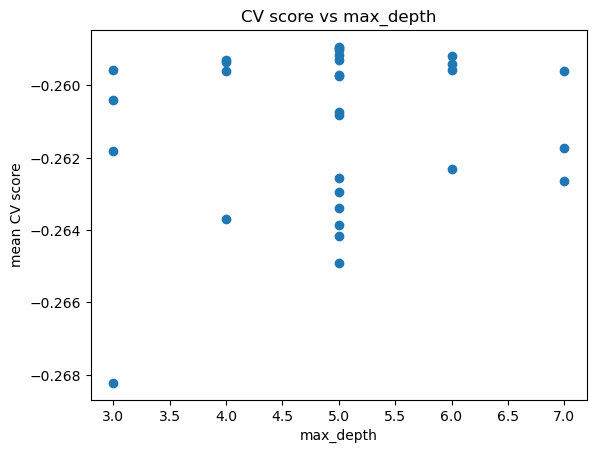

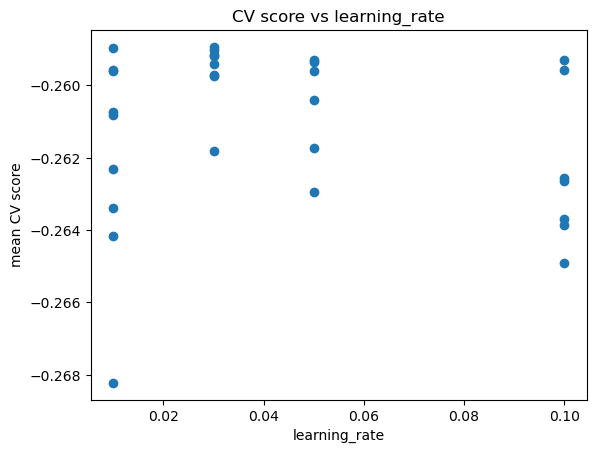

In [11]:
results = pd.DataFrame(search.cv_results_)

# Top 10 configs
top = results.sort_values("mean_test_score", ascending=False).head(10)
display(top[["mean_test_score","std_test_score","param_max_depth","param_learning_rate","param_n_estimators",
             "param_subsample","param_colsample_bytree","param_min_child_weight","param_gamma","param_reg_alpha","param_reg_lambda"]])

# score vs max_depth
plt.figure()
plt.scatter(results["param_max_depth"], results["mean_test_score"])
plt.xlabel("max_depth")
plt.ylabel("mean CV score")
plt.title("CV score vs max_depth")
plt.show()

# score vs learning_rate
plt.figure()
plt.scatter(results["param_learning_rate"], results["mean_test_score"])
plt.xlabel("learning_rate")
plt.ylabel("mean CV score")
plt.title("CV score vs learning_rate")
plt.show()

In [12]:
best_params = search.best_params_      
y_proba = best_model.predict_proba(X_val_all)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

run = wandb.init(
    project="projet-hockey-ai",
    name="xgboost-all-features-tuned",
    tags=["xgboost", "tuned", "all-features"],
    config=best_params,          # log automatiquement les hyperparams
    save_code=True
)


model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    **best_params
)

model.fit(X_train_all, y_train_all)

y_proba = model.predict_proba(X_val_all)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

metrics = {
    "val/accuracy": accuracy_score(y_val_all, y_pred),
    "val/auc": roc_auc_score(y_val_all, y_proba),
    "val/log_loss": log_loss(y_val_all, y_proba),
}
print(metrics)
wandb.log(metrics)

wandb.sklearn.plot_classifier(
        model,
        X_train_all, X_val_all,
        y_train_all, y_val_all,
        y_pred,
        np.column_stack([1 - y_proba, y_proba]),
        labels=["Non-Goal", "Goal"],
        model_name="XGBoost Tuned (All features)",
        feature_names=list(X_train_all.columns)
)

model_path = "xgb_all_features_tuned.json"
model.get_booster().save_model(model_path)

artifact = wandb.Artifact(
    name="xgb-all-features-tuned",
    type="model",
    metadata={
        **best_params,
        "target": "isGoal",
        "n_features": X_train_all.shape[1],
        "features": list(X_train_all.columns),
        **metrics
    }
)
artifact.add_file(model_path)
run.log_artifact(artifact, aliases=["best", "q2"])

run.finish()

{'val/accuracy': 0.9103086957185844, 'val/auc': 0.7922945248906522, 'val/log_loss': 0.25769226588052724}


wandb: 
wandb: Plotting XGBoost Tuned (All features).
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: WARNING X contains 43217 missing values. 
wandb: WARNING X_test contains 10608 missing values. 
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING X contains 43217 missing values. 
wandb: Logged calibration curve.
wandb: WARNING wandb uses only 10000 data points to create the plots.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


val/accuracy,▁
val/auc,▁
val/log_loss,▁
val/accuracy,0.91031
val/auc,0.79229
val/log_loss,0.25769


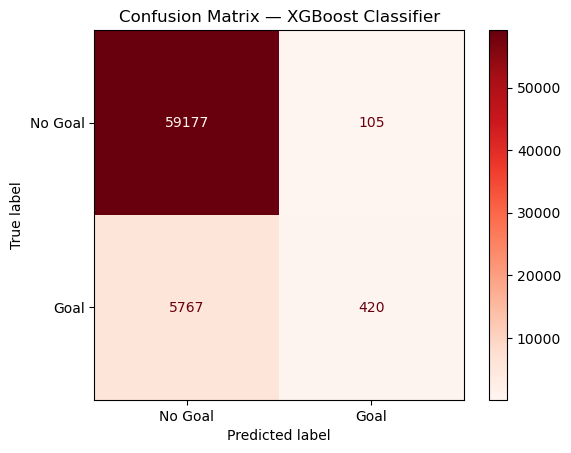

In [13]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_val_all, y_pred,
    display_labels=["No Goal", "Goal"],   
    values_format="d",
    cmap="Reds"
)
plt.title("Confusion Matrix — XGBoost Classifier")
plt.grid(False)
plt.show()

# Feature Selection

## SHAP 

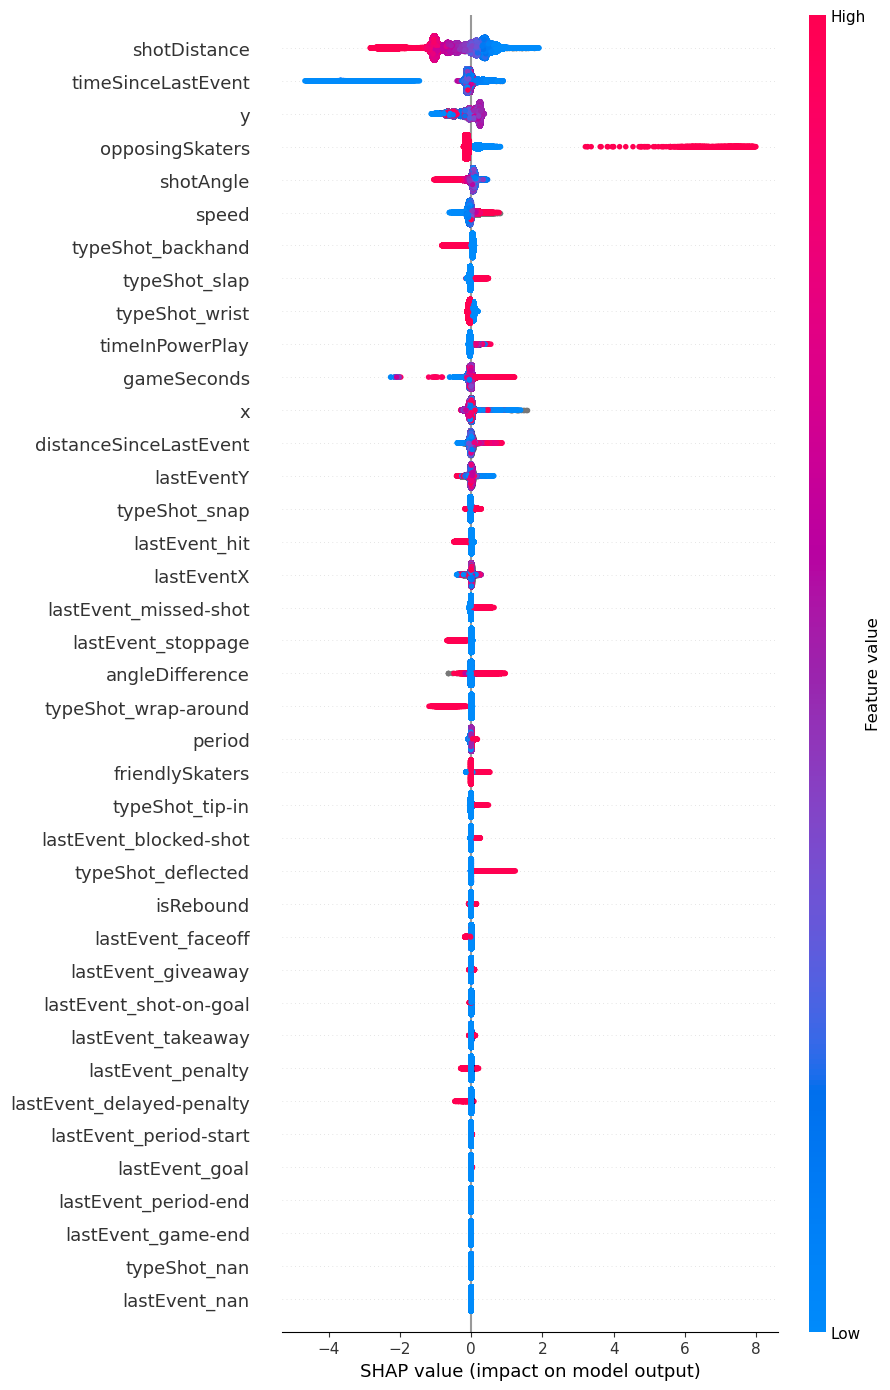

In [14]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_all)
# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values, max_display=100)

In [16]:
# On calcule l'importance moyenne 
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

feature_importance = pd.DataFrame({
    'col_name': shap_values.feature_names,
    'score': mean_abs_shap
})

# On trie du meilleur score au pire
feature_importance = feature_importance.sort_values(by='score', ascending=False)

cols_top15 = feature_importance['col_name'].head(15).tolist()
cols_top10 = feature_importance['col_name'].head(10).tolist()
cols_top5  = feature_importance['col_name'].head(5).tolist()

# Création des dataframe avec les meilleurs
X_top15 = X_all[cols_top15]
X_top10 = X_all[cols_top10]
X_top5  = X_all[cols_top5]

X_train_top15, X_val_top15, y_train_all, y_val_all = train_test_split(
    X_top15, y_all, test_size=0.2, random_state=42, stratify=y_all
)
X_train_top10, X_val_top10, y_train_all, y_val_all = train_test_split(
    X_top10, y_all, test_size=0.2, random_state=42, stratify=y_all
)
X_train_top5, X_val_top5, y_train_all, y_val_all = train_test_split(
    X_top5, y_all, test_size=0.2, random_state=42, stratify=y_all
)

## Modèle XGBoost Top 5

In [17]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-baseline-top-5",
    tags=["baseline", "xgboost"],
    save_code=True
)

XGBoost_top5 = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

XGBoost_top5.fit(X_train_top5, y_train_all)

# Prédictions
y_pred_top5 = XGBoost_top5.predict(X_val_top5)
y_proba_top5 = XGBoost_top5.predict_proba(X_val_top5)

# 6. Calcul des métriques
acc_top5 = accuracy_score(y_val_all, y_pred_top5)
auc_top5 = roc_auc_score(y_val_all, y_proba_top5[:, 1])
ll_top5 = log_loss(y_val_all, y_proba_top5[:, 1])

print(f"Accuracy: {acc_top5}")
print(f"AUC: {auc_top5}")
print(f"Log Loss: {ll_top5}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    XGBoost_top5, X_train_top5, X_val_top5, y_train_all, y_val_all,
    y_pred_top5, y_proba_top5, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost Baseline', 
    feature_names=cols_top5
)

wandb.log({"accuracy": acc_top5, "auc": auc_top5, "log_loss": ll_top5})

run.finish()

Accuracy: 0.909651896317341
AUC: 0.7752721720561151
Log Loss: 0.2647980348971418


wandb: 
wandb: Plotting XGBoost Baseline.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: WARNING X contains 34 missing values. 
wandb: WARNING X_test contains 18 missing values. 
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING X contains 34 missing values. 
wandb: Logged calibration curve.
wandb: WARNING wandb uses only 10000 data points to create the plots.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.90965
auc,0.77527
log_loss,0.2648


## Modèle XGBoost Top 10

In [18]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-baseline-top-10",
    tags=["baseline", "xgboost"],
    save_code=True
)

XGBoost_top10 = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

XGBoost_top10.fit(X_train_top10, y_train_all)

# Prédictions
y_pred_top10 = XGBoost_top10.predict(X_val_top10)
y_proba_top10 = XGBoost_top10.predict_proba(X_val_top10)

# 6. Calcul des métriques
acc_top10 = accuracy_score(y_val_all, y_pred_top10)
auc_top10 = roc_auc_score(y_val_all, y_proba_top10[:, 1])
ll_top10 = log_loss(y_val_all, y_proba_top10[:, 1])

print(f"Accuracy: {acc_top10}")
print(f"AUC: {auc_top10}")
print(f"Log Loss: {ll_top10}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    XGBoost_top10, X_train_top10, X_val_top10, y_train_all, y_val_all,
    y_pred_top10, y_proba_top10, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost Baseline', 
    feature_names=cols_top10
)

wandb.log({"accuracy": acc_top10, "auc": auc_top10, "log_loss": ll_top10})

run.finish()

Accuracy: 0.9096977195313812
AUC: 0.7798608898107212
Log Loss: 0.2634867632057213


wandb: 
wandb: Plotting XGBoost Baseline.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: WARNING X contains 14094 missing values. 
wandb: WARNING X_test contains 3495 missing values. 
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING X contains 14094 missing values. 
wandb: Logged calibration curve.
wandb: WARNING wandb uses only 10000 data points to create the plots.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.9097
auc,0.77986
log_loss,0.26349


## Modèle XGBoost Top 15

In [19]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-baseline-top-15",
    tags=["baseline", "xgboost"],
    save_code=True
)

XGBoost_top15 = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

XGBoost_top15.fit(X_train_top15, y_train_all)

# Prédictions
y_pred_top15 = XGBoost_top15.predict(X_val_top15)
y_proba_top15 = XGBoost_top15.predict_proba(X_val_top15)

# 6. Calcul des métriques
acc_top15 = accuracy_score(y_val_all, y_pred_top15)
auc_top15 = roc_auc_score(y_val_all, y_proba_top15[:, 1])
ll_top15 = log_loss(y_val_all, y_proba_top15[:, 1])

print(f"Accuracy: {acc_top15}")
print(f"AUC: {auc_top15}")
print(f"Log Loss: {ll_top15}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    XGBoost_top15, X_train_top15, X_val_top15, y_train_all, y_val_all,
    y_pred_top15, y_proba_top15, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost Baseline', 
    feature_names=cols_top15
)

wandb.log({"accuracy": acc_top15, "auc": auc_top15, "log_loss": ll_top15})

run.finish()

Accuracy: 0.9094227802471399
AUC: 0.7802965841977747
Log Loss: 0.26280319206888464


wandb: 
wandb: Plotting XGBoost Baseline.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: WARNING X contains 33511 missing values. 
wandb: WARNING X_test contains 8238 missing values. 
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING X contains 33511 missing values. 
wandb: Logged calibration curve.
wandb: WARNING wandb uses only 10000 data points to create the plots.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.90942
auc,0.7803
log_loss,0.2628


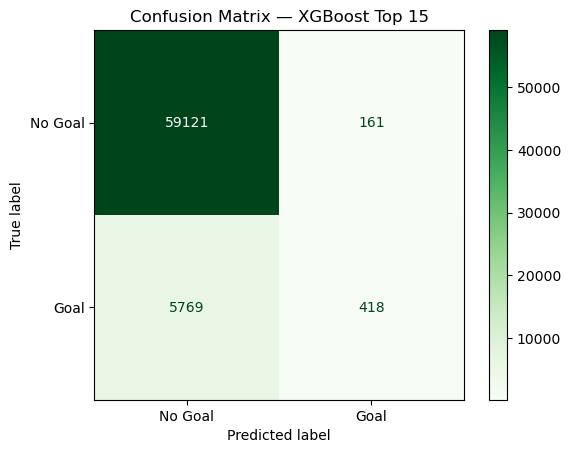

In [35]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_val_all, y_pred_top15,
    display_labels=["No Goal", "Goal"],   
    values_format="d",
    cmap="Greens"
)
plt.title("Confusion Matrix — XGBoost Top 15")
plt.grid(False)
plt.show()

# Comparaison des modèles

### Courbes ROC-AUC 

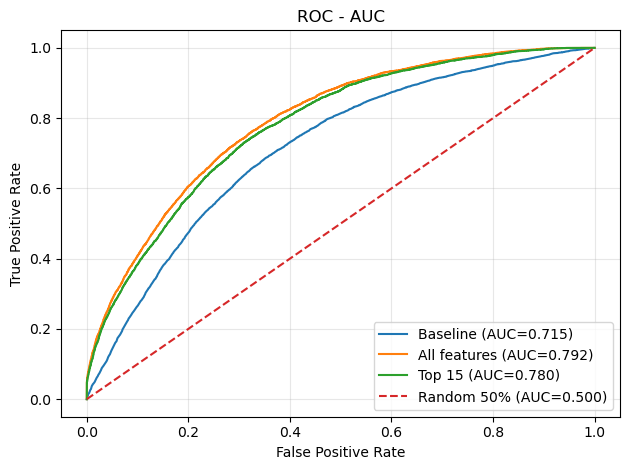

In [33]:
# Proba
pos_idx_distance_angle  = np.where(XGBoost_distance_angle.classes_  == 1)[0][0]
pos_idx_all = np.where(model.classes_ == 1)[0][0]
pos_idx_top15 = np.where(XGBoost_top15.classes_ == 1)[0][0]


proba_distance_angle  = XGBoost_distance_angle.predict_proba(X_val_distance_angle)[:,  pos_idx_distance_angle]
proba_all = model.predict_proba(X_val_all)[:,  pos_idx_all]
proba_top15  = XGBoost_top15.predict_proba(X_val_top15)[:,  pos_idx_top15]


# ROC-AUC
fpr_distance_angle,  tpr_distance_angle,  _ = roc_curve(y_val_distance_angle, proba_distance_angle)
auc_distance_angle = roc_auc_score(y_val_distance_angle, proba_distance_angle)
fpr_all, tpr_all, _ = roc_curve(y_val_all, y_proba)
auc_all = roc_auc_score(y_val_all, y_proba)
fpr_top15, tpr_top15, _ = roc_curve(y_val_all, proba_top15)
auc_top15 = roc_auc_score(y_val_all, proba_top15)

plt.plot(fpr_distance_angle,  tpr_distance_angle,  label=f"Baseline (AUC={auc_distance_angle:.3f})")
plt.plot(fpr_all,  tpr_all,  label=f"All features (AUC={auc_all:.3f})")
plt.plot(fpr_top15,  tpr_top15,  label=f"Top 15 (AUC={auc_top15:.3f})")


plt.plot([0, 1], [0, 1], linestyle="--", label="Random 50% (AUC=0.500)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Taux de buts en fonction du centile de la probabilité de tir

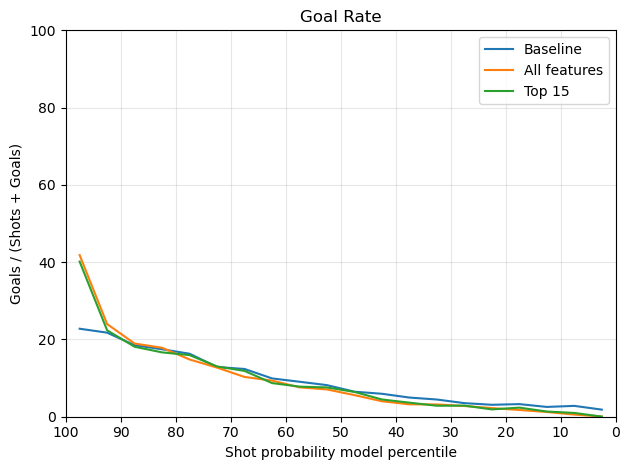

In [32]:
x_distance_angle, goal_rate_distance_angle = goal_rate_by_percentile(y_val_distance_angle, proba_distance_angle, step=5)
goal_rate_percent_distance_angle = 100.0 * goal_rate_distance_angle

x_all, goal_rate_all = goal_rate_by_percentile(y_val_all, proba_all, step=5)
goal_rate_percent_all = 100.0 * goal_rate_all

x_top15, goal_rate_top15 = goal_rate_by_percentile(y_val_all, proba_top15, step=5)
goal_rate_percent_top15 = 100.0 * goal_rate_top15

plt.plot(x_distance_angle,  goal_rate_percent_distance_angle,  label="Baseline")
plt.plot(x_all, goal_rate_percent_all, label="All features")
plt.plot(x_top15, goal_rate_percent_top15, label="Top 15")

plt.title("Goal Rate")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

### Proportion cumulée de but en fonction du centile de la probabilité de tir

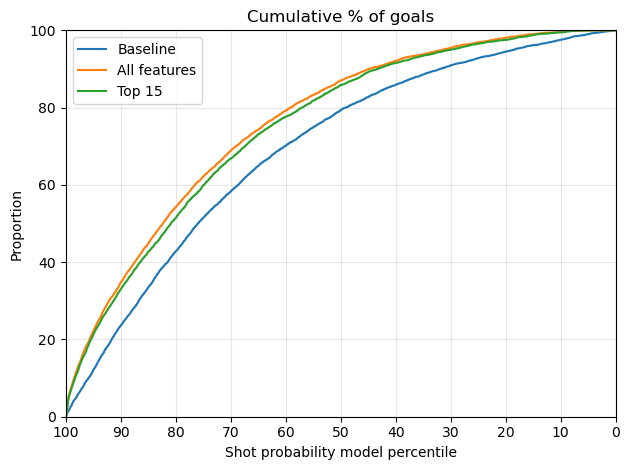

In [31]:
plot_goal_curve(y_val_distance_angle, proba_distance_angle, "Baseline")
plot_goal_curve(y_val_all, proba_all, "All features")
plot_goal_curve(y_val_all, proba_top15, "Top 15")

plt.title("Cumulative % of goals")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Proportion")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

### Diagramme de fiabilité

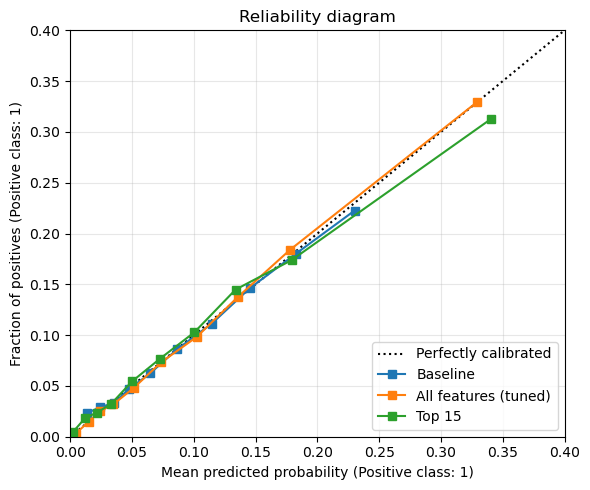

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))

CalibrationDisplay.from_predictions(
    y_true=y_val_distance_angle,
    y_prob=proba_distance_angle,
    n_bins=10,
    strategy="quantile",
    name="Baseline",
    ax=ax
)

CalibrationDisplay.from_predictions(
    y_true=y_val_all,
    y_prob=proba_all,
    n_bins=10,
    strategy="quantile",
    name="All features (tuned)",
    ax=ax
)

CalibrationDisplay.from_predictions(
    y_true=y_val_all,
    y_prob=proba_top15,
    n_bins=10,
    strategy="quantile",
    name="Top 15",
    ax=ax
)

ax.set_xlim(0, 0.40)
ax.set_ylim(0, 0.40)
ax.grid(alpha=0.3)
ax.set_title("Reliability diagram")
plt.tight_layout()
plt.show()